# Deep Learning: Long Short-Term Memory (LSTM)


## 1. Introduction

Five years of Reliance Industry historical stock data will be used to predict Adjusted Close prices by building a multi-layer LSTM Recurrent Neural Network model. The ability to store information over a period of time is useful when dealing with time series data. 



## 2. Install/import libraries

In [1]:
!pip install yfinance as yfinance

ERROR: Could not find a version that satisfies the requirement as (from versions: none)
ERROR: No matching distribution found for as


In [53]:
import yfinance as yf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import seaborn as sns
import math
import datetime
import keras
import warnings
warnings.filterwarnings('ignore')

from datetime import date, timedelta
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

%matplotlib inline

## 3. Import data

Read in Reliance Industry stock data for 2018-2023 downloaded from Yahoo! Finance using yfinance API into a pandas DataFrame.

In [54]:
RI_df = yf.download("RELIANCE.NS", start="2018-06-03", end="2023-06-04")
RI_df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-06-04,924.635376,935.135864,921.812134,932.015442,912.066833,5653442
2018-06-05,933.947144,946.032532,932.164001,938.751587,918.658813,8047086
2018-06-06,938.107666,947.023193,933.798523,945.438171,925.202209,4229195
2018-06-07,945.933472,966.835388,945.487732,962.229004,941.633667,6922300
2018-06-08,957.276001,977.286316,951.579956,975.106934,954.235962,6594521
...,...,...,...,...,...,...
2023-05-29,2521.000000,2530.000000,2507.199951,2520.600098,2520.600098,4619754
2023-05-30,2520.600098,2537.699951,2514.350098,2519.949951,2519.949951,5234564
2023-05-31,2500.000000,2509.850098,2461.000000,2469.899902,2469.899902,12510304


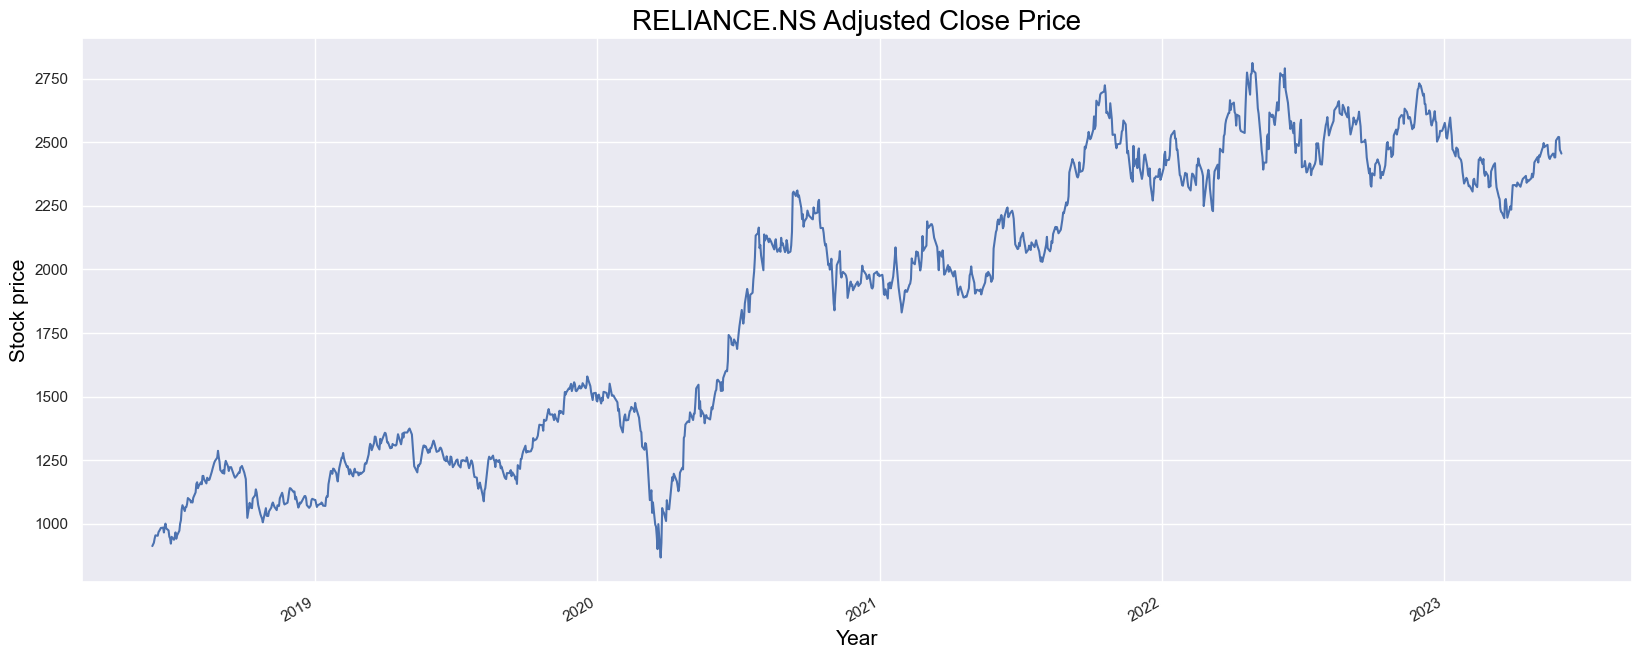

In [55]:
# Plot Adjusted Close price

RI_df['Adj Close'].plot(grid = True)
sns.set(rc={'figure.figsize':(20, 8)})
plt.title('RELIANCE.NS Adjusted Close Price', color = 'black', fontsize = 20)
plt.xlabel('Year', color = 'black', fontsize = 15)
plt.ylabel('Stock price', color = 'black', fontsize = 15);

In [41]:
# Create DataFrame for Adjusted Close price

RI_adj = RI_df[['Adj Close']]

In [43]:
RI_adj

,Adj Close
Date,
2018-06-04,912.066833
2018-06-05,918.658691
2018-06-06,925.202209
2018-06-07,941.633667
2018-06-08,954.235962
...,...
2023-05-29,2520.600098
2023-05-30,2519.949951
2023-05-31,2469.899902


## 4. Create training data set

In [56]:
# Convert DataFrame to numpy array
RI_adj_arr = RI_adj.values

# Find number of rows to train model on (80% of data set) 
training_data_len = int(0.8*len(RI_adj))

training_data_len

988

In [57]:
# Create train data set

train = RI_adj_arr[0:training_data_len, :]

### Feature scaling

We will normalise the training data before model fitting by converting the values of numeric columns in the data set to a common scale. Scikit-Learn’s MinMaxScaler() function scales the data to values between 0 and 1 which helps boost performance.

In [58]:
# Normalise the data
scaler = MinMaxScaler(feature_range=(0,1))
train_scaled = scaler.fit_transform(train)

train_scaled

array([[0.02314549],
       [0.0265358 ],
       [0.02990125],
       [0.03835225],
       [0.04483384],
       [0.04398627],
       [0.0512157 ],
       [0.05388316],
       [0.05660041],
       [0.05971658],
       [0.06038968],
       [0.05066726],
       [0.06223446],
       [0.06856647],
       [0.05886901],
       [0.05485539],
       [0.04214152],
       [0.03857974],
       [0.02809505],
       [0.04189067],
       [0.03594606],
       [0.04131379],
       [0.05074492],
       [0.0379025 ],
       [0.04444914],
       [0.05425653],
       [0.06860399],
       [0.07517573],
       [0.09702296],
       [0.10577686],
       [0.09393774],
       [0.10203957],
       [0.1021399 ],
       [0.10831028],
       [0.12024978],
       [0.11606084],
       [0.11137038],
       [0.11347732],
       [0.11121983],
       [0.12085175],
       [0.13166248],
       [0.1490199 ],
       [0.15220539],
       [0.14016549],
       [0.14447988],
       [0.15233083],
       [0.14811683],
       [0.164

In [59]:
train_scaled.shape

(988, 1)

## Split training data into X_train, y_train

In [60]:
# Creating a data structure with 60 time-steps and 1 output

# Split data into X_train and y_train data sets
X_train = []
y_train = []
# Creating a data structure with 60 time-steps and 1 output
for i in range(60, len(train_scaled)):
    X_train.append(train_scaled[i-60:i, 0])
    y_train.append(train_scaled[i:i+1, 0])  
    if i <= 61:     # 60 days for first pass, 61 for second
      print(X_train)
      print(y_train)
      print()

[array([0.02314549, 0.0265358 , 0.02990125, 0.03835225, 0.04483384,
       0.04398627, 0.0512157 , 0.05388316, 0.05660041, 0.05971658,
       0.06038968, 0.05066726, 0.06223446, 0.06856647, 0.05886901,
       0.05485539, 0.04214152, 0.03857974, 0.02809505, 0.04189067,
       0.03594606, 0.04131379, 0.05074492, 0.0379025 , 0.04444914,
       0.05425653, 0.06860399, 0.07517573, 0.09702296, 0.10577686,
       0.09393774, 0.10203957, 0.1021399 , 0.10831028, 0.12024978,
       0.11606084, 0.11137038, 0.11347732, 0.11121983, 0.12085175,
       0.13166248, 0.1490199 , 0.15220539, 0.14016549, 0.14447988,
       0.15233083, 0.14811683, 0.16492246, 0.16504784, 0.15815006,
       0.14987269, 0.16136059, 0.15644443, 0.15792429, 0.17355098,
       0.17972136, 0.19088336, 0.19492162, 0.20194484, 0.21574053])]
[array([0.20329932])]

[array([0.02314549, 0.0265358 , 0.02990125, 0.03835225, 0.04483384,
       0.04398627, 0.0512157 , 0.05388316, 0.05660041, 0.05971658,
       0.06038968, 0.05066726, 0.06

In [61]:
# Convert X_train and y_train to numpy arrays for training LSTM model
X_train, y_train = np.array(X_train), np.array(y_train)

In [62]:
# Reshape the data as LSTM expects 3-D data (samples, time steps, features)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(928, 60, 1)

### Create and train model

We will create and train a model with four recurrent layers each with 50 neurons, input shape of data with number of time steps (60) and dimensionality (1), and an output layer with time step of 1, and the tanh activation function. Dropout will be used after each hidden layer as a regularisation technique to prevent overfitting. The model will be compiled using the Mean Squared Error loss function and the adam (Adaptive Moment Estimation) optimizer then fitted on the training set for 200 epochs with a batch size of 64.

In [63]:
# Build model - LSTM with 50 neurons and 4 hidden layers  

model = Sequential()
#Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1), activation='tanh'))
model.add(Dropout(0.2))
# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True, activation='tanh'))
model.add(Dropout(0.2))
# Adding a third LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True, activation='tanh'))
model.add(Dropout(0.2))
# Adding a fourth LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, activation='tanh'))
model.add(Dropout(0.2))
# Adding the output layer
model.add(Dense(units = 1))
# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
# Fitting the RNN to the Training set
model.fit(X_train, y_train, epochs = 200, batch_size = 64)

Epoch 1/200
15/15 [==============================] - 9s 110ms/step - loss: 0.0744
Epoch 2/200
15/15 [==============================] - 2s 111ms/step - loss: 0.0152
Epoch 3/200
15/15 [==============================] - 2s 144ms/step - loss: 0.0085
Epoch 4/200
15/15 [==============================] - 2s 147ms/step - loss: 0.0077
Epoch 5/200
15/15 [==============================] - 2s 156ms/step - loss: 0.0076
Epoch 6/200
15/15 [==============================] - 2s 139ms/step - loss: 0.0065
Epoch 7/200
15/15 [==============================] - 2s 137ms/step - loss: 0.0064
Epoch 8/200
15/15 [==============================] - 2s 141ms/step - loss: 0.0063
Epoch 9/200
15/15 [==============================] - 2s 138ms/step - loss: 0.0062
Epoch 10/200
15/15 [==============================] - 2s 145ms/step - loss: 0.0057
Epoch 11/200
15/15 [==============================] - 2s 141ms/step - loss: 0.0062
Epoch 12/200
15/15 [==============================] - 2s 165ms/step - loss: 0.0063
Epoch 13/200


### Create test set

In [64]:
test = RI_adj_arr[training_data_len: , :]

In [65]:
test.shape

(247, 1)

In [66]:
# Predicting 253 values, using past 60 from the train data
inputs = RI_adj_arr[len(RI_adj_arr) - len(test) - 60:]
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

In [67]:
# Create data sets X_test and y_test
X_test = []
y_test = RI_adj_arr[training_data_len:, :]
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])

In [68]:
# Convert data to numpy array
X_test = np.array(X_test)

In [69]:
# Reshape data to be 3-D
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [70]:
print(X_test.shape)

(247, 60, 1)


### Make Predictions using the test set

In [71]:
# We want predictions to contain same values as y_test data set
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

8/8 [==============================] - 2s 34ms/step


In [72]:
predictions.shape

(247, 1)

### Calculate the RMSE using the actual values

RMSE is the standard deviation of the residuals and is a good measure of how accurately the model predicts the reponse. Lower values of RMSE indicate a better fit.

In [73]:
rmse = np.sqrt(np.mean(predictions - y_test)**2)  
rmse

5.963654676429656

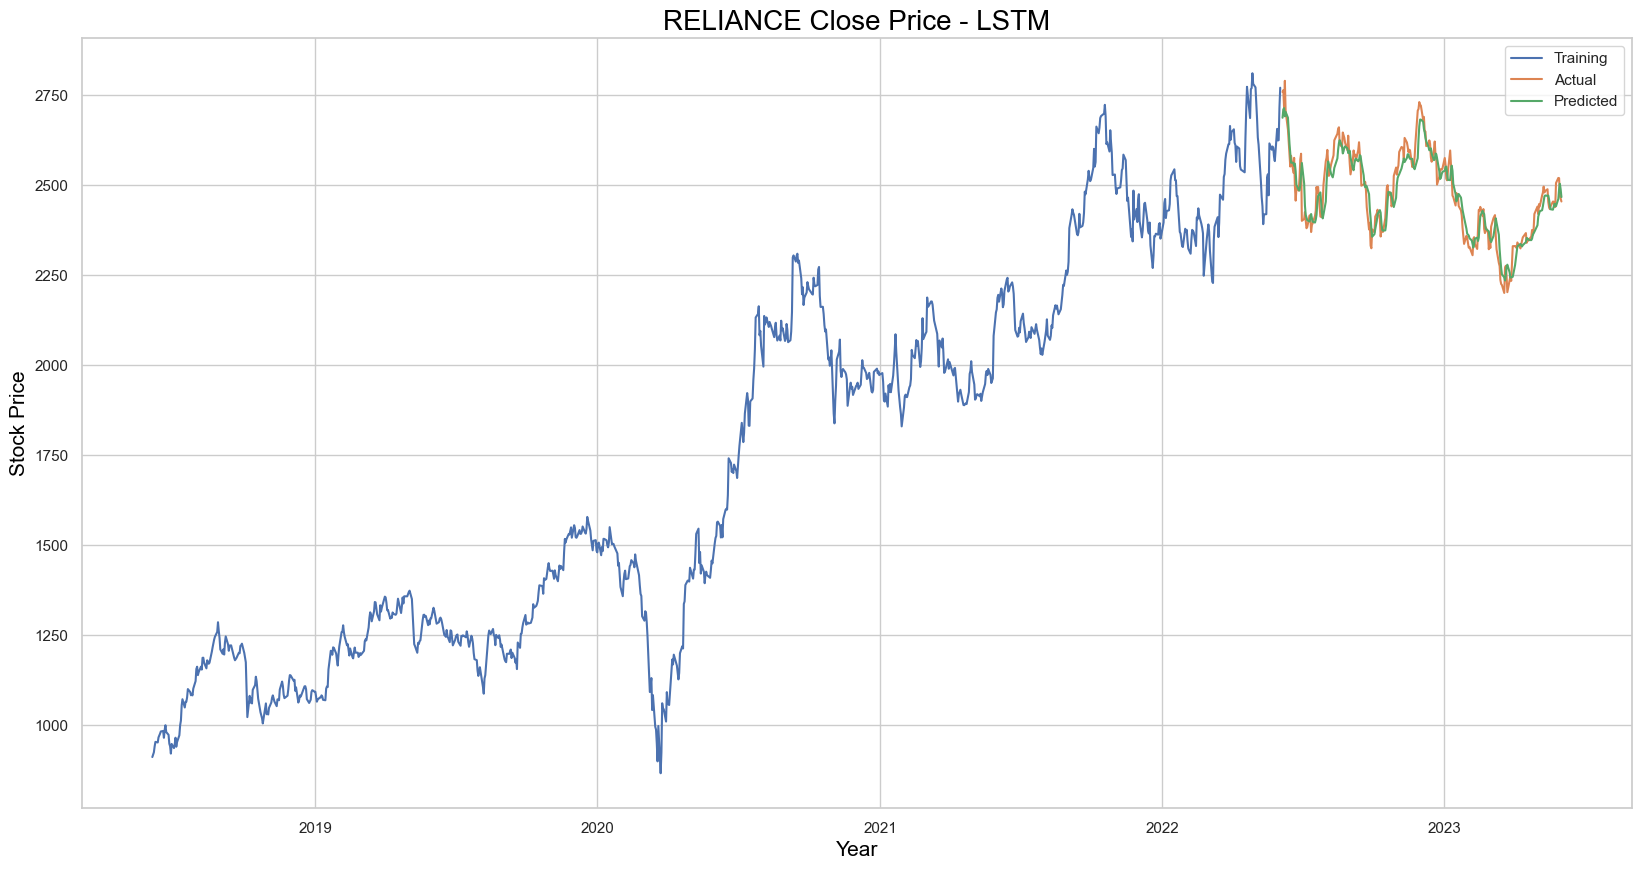

In [74]:
# Plot predicted vs actual values  
train = RI_adj[:training_data_len]
test = RI_adj[training_data_len:]
test['Predictions'] = predictions

plt.figure(figsize=(20,10))
sns.set_style("whitegrid")
plt.plot(train['Adj Close'], label='Training')
plt.plot(test['Adj Close'], label='Actual')
plt.plot(test['Predictions'], label='Predicted')
plt.title("RELIANCE Close Price - LSTM", color = 'black', fontsize = 20)
plt.xlabel('Year', color = 'black', fontsize = 15)
plt.ylabel('Stock Price', color = 'black', fontsize = 15)
plt.legend();

### DataFrame of actual vs predicted prices plotted above

In [75]:
# Show the actual and predicted prices  

test

,Adj Close,Predictions
Date,,
2022-06-06,2759.242676,2687.791016
2022-06-07,2764.427002,2710.661133
2022-06-08,2715.873291,2714.548584
2022-06-09,2790.349121,2691.858398
2022-06-10,2706.102783,2704.141846
...,...,...
2023-05-29,2520.600098,2462.430420
2023-05-30,2519.949951,2489.169922
2023-05-31,2469.899902,2504.275146


### Predict Adjusted Close price for 05 June 2023

In [93]:
# Predict Adjusted Close price for RI stock for 04 June 2023   
# get the quote
RI_quote = yf.download("RELIANCE.NS", start="2018-06-03", end="2023-06-06")
# Create new df
new_df = RI_quote.filter(['Adj Close'])
# Get last 60 days closing price and convert df to array])
last_60_days = new_df[-60:].values
# Scale data to be values between 0 and 1
last_60_days_scaled = scaler.transform(last_60_days)
# Create empty list
X_test = []
# Append last 60 days 
X_test.append(last_60_days_scaled)
# Convert the X_test data set to numpy array
X_test = np.array(X_test)
# Reshape data
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
# Get predicted price
pred_price = model.predict(X_test)
# Undo the scaling
pred_price = scaler.inverse_transform(pred_price)
print(pred_price)

[*********************100%***********************]  1 of 1 completed
1/1 [==============================] - 0s 72ms/step
[[2453.867]]


### Actual Adjusted Close price for 05 June 2023

In [94]:
# Actual price

RI_quote2 = yf.download("RELIANCE.NS", start="2018-06-04", end="2023-06-06")
print(RI_quote2['Adj Close'])

[*********************100%***********************]  1 of 1 completed
Date
2018-06-04     912.066772
2018-06-05     918.658752
2018-06-06     925.202209
2018-06-07     941.633667
2018-06-08     954.235962
                 ...     
2023-05-30    2519.949951
2023-05-31    2469.899902
2023-06-01    2463.250000
2023-06-02    2455.199951
2023-06-05    2477.250000
Name: Adj Close, Length: 1236, dtype: float64


The predicted Adjusted Close price for 05 June 2023 was 2453.87, lower than the actual price of 2477.25. Accuracy could be improved by trying different numbers of layers, epochs and batch sizes. 